In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# 0. Inicializando Ambiente Django no Notebook

In [2]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

from django_for_jupyter import init_django
init_django('app')

# 1. Lendo do Banco de Dados e Salvando em um DataFrame Pandas

In [132]:
from api.models import TextosJuridicosTreinamento

qs = TextosJuridicosTreinamento.objects.all()
data = qs.values('teor_texto', 'orgao_julgador', 'classe_processo', 'assuntos', 'setor_destino')

df = pd.DataFrame(data)
df.head(5)

,teor_texto,orgao_julgador,classe_processo,assuntos,setor_destino
0,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,2ª VIJ da Com. Natal,1706,12485;12494,Saúde
1,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,3º JFP da Com. Natal,14695,10715,Administrativa
2,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,5ª VEFT de Natal,156,9518,Fiscal
3,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,1ª VEFT de Natal,12078,10534;5952,Fiscal
4,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,5ª VFP da Com. Natal,12078,10311,Administrativa


In [27]:
# Do LabelEncoder, temos:
dict_encod = {0:'Administrativa',
              1:'Contabilidade',
              2:'Fiscal',
              3:'Judicial',
              4:'Meio Ambiente',
              5:'Patrimonial',
              6:'Saúde'}

# 2. Lendo os embeddings

In [ ]:
import torch

load_dir = '/home/esdras-daniel/Documentos/Python/Django/PGM-Text_Classificator/notebooks/embeddings'
embeddings_file_name = 'embeddings_mean.pt'

X = torch.load(os.path.join(load_dir, embeddings_file_name))
y = torch.load(os.path.join(load_dir, 'labels.pt'))

## 2.1 - Separação de treinamento/teste

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)

# Calculando os pesos das classes (Usando apenas o conjunto de treinamento)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.numpy())
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

## 2.2 - Balanceamento usando SMOTE/RandomUnderSampler

In [72]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

under_sampling_dict = {
    0: 1000,
    2: 1000,
}

under_sampler = RandomUnderSampler(sampling_strategy=under_sampling_dict)
over_sampler = SMOTE()

# Under Sampling
X_train_balanced, y_train_balanced = under_sampler.fit_resample(X_train, y_train)

# Over Sampling
X_train_balanced, y_train_balanced = over_sampler.fit_resample(X_train_balanced, y_train_balanced)

# 3. Treinamento

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

def plot_classification_results(y_true, y_pred, dict_encod, unknown_class='Não Identificada'):

    if type(y_true) == torch.Tensor:
        y_true = y_true.numpy()

    if type(y_pred) == torch.Tensor:
        y_pred = y_pred.numpy()

    # Mapear valores para nomes de classe
    label_names = [dict_encod[k] for k in sorted(dict_encod.keys())]
    label_map = dict_encod

    # Converter y_true e y_pred para nomes de classe
    y_true_names = [label_map.get(val, str(val)) for val in y_true]
    y_pred_names = [
        unknown_class if val == unknown_class or val not in label_map else label_map[val]
        for val in y_pred
    ]

    num_classes = len(label_names)
    has_unknown = unknown_class in y_pred_names
    num_columns = num_classes + int(has_unknown)

    # Construir matriz manualmente
    cm_matrix = np.zeros((num_classes, num_classes + int(has_unknown)), dtype=int)
    name_to_index = {name: idx for idx, name in enumerate(label_names)}

    for yt, yp in zip(y_true_names, y_pred_names):
        if yt not in name_to_index:
            continue
        row_idx = name_to_index[yt]
        col_idx = name_to_index.get(yp, num_classes)  # última coluna para desconhecida
        cm_matrix[row_idx, col_idx] += 1

    # Normaliza por linha
    cm_norm = cm_matrix.astype(float)
    for i in range(num_classes):
        row_sum = cm_matrix[i].sum()
        if row_sum > 0:
            cm_norm[i] = cm_matrix[i] / row_sum

    # Labels das colunas
    col_labels = label_names.copy()
    if has_unknown:
        col_labels.append(unknown_class)

    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Matriz de confusão
    ax1 = axes[0]
    sns.heatmap(cm_norm, annot=False, fmt='d', cmap='Blues',
                xticklabels=col_labels, yticklabels=label_names, ax=ax1, cbar=False, vmin=0, vmax=1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    ax1.set_title('Matriz de Confusão')
    ax1.set_xlabel('Predito')
    ax1.set_ylabel('Real')

    # Adicionar Quantidade + recall
    for i in range(num_classes):
        for j in range(num_columns):
            count = cm_matrix[i, j]
            if i == j and cm_matrix[i].sum() > 0:
                annotation = f'{count}\nR={cm_norm[i, j]:.2f}'
            else:
                annotation = str(count)
            ax1.text(j +0.5, i+0.5, annotation, ha='center', va='center', fontsize=10, color='black')

    # Classification report
    '''ax2 = axes[1]
    report_dict = classification_report(y_true_names, y_pred_names, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose().round(2)
    ax2.axis('off')
    table = ax2.table(cellText=report_df.values,
                      colLabels=report_df.columns,
                      rowLabels=report_df.index,
                      loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax2.set_title('Classification Report')'''
    ax2 = axes[1]
    report_text = classification_report(y_true_names, y_pred_names, zero_division=0)
    ax2.axis('off')
    ax2.set_title('Classification Report', fontsize=14, loc='left')
    ax2.text(0, 1, report_text, fontsize=14, family='monospace', verticalalignment='top')

    plt.tight_layout()
    plt.show()


## 3.1 - RandomForest

### 3.1.1 - Unbalanced - Weight balanced

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(class_weight='balanced')
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print(rf_clf.score(X_test, y_test))

0.8676117775354416


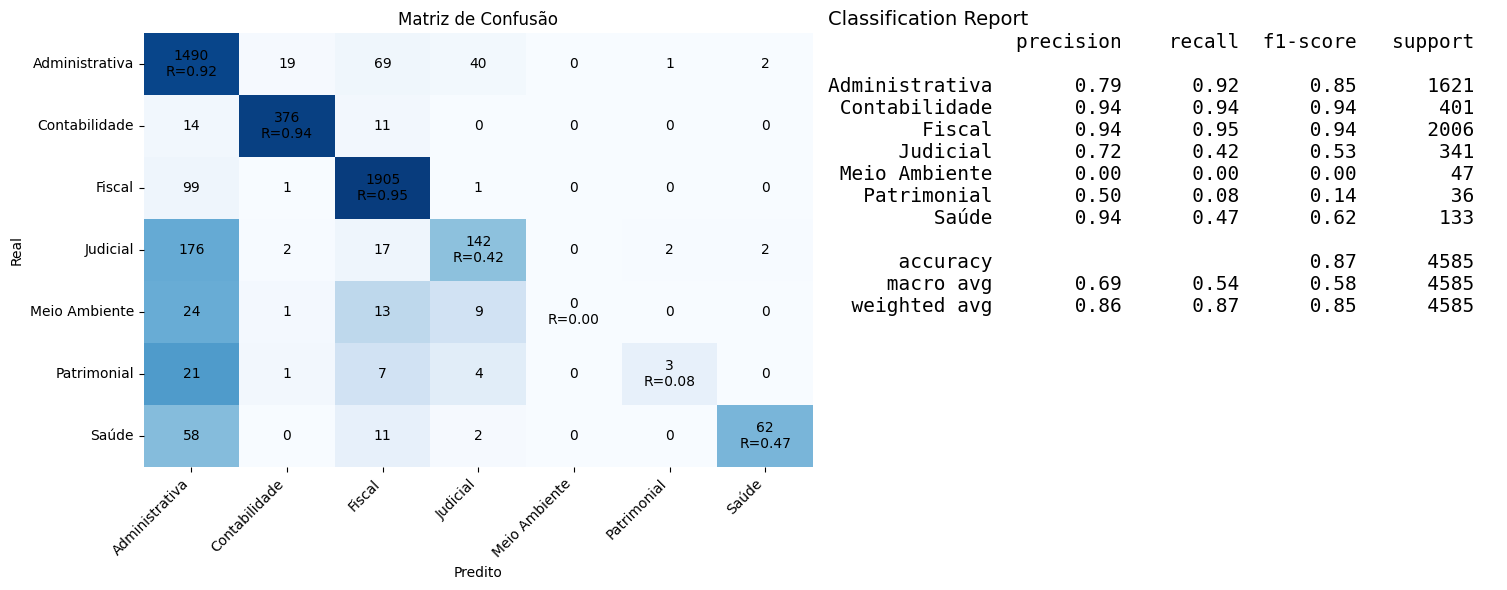

In [77]:
plot_classification_results(y_true=y_test, y_pred=y_pred_rf, dict_encod=dict_encod)

### 3.1.2 - Balanced

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_clf.predict(X_test)

print(rf_clf.score(X_test, y_test))

0.812649945474373


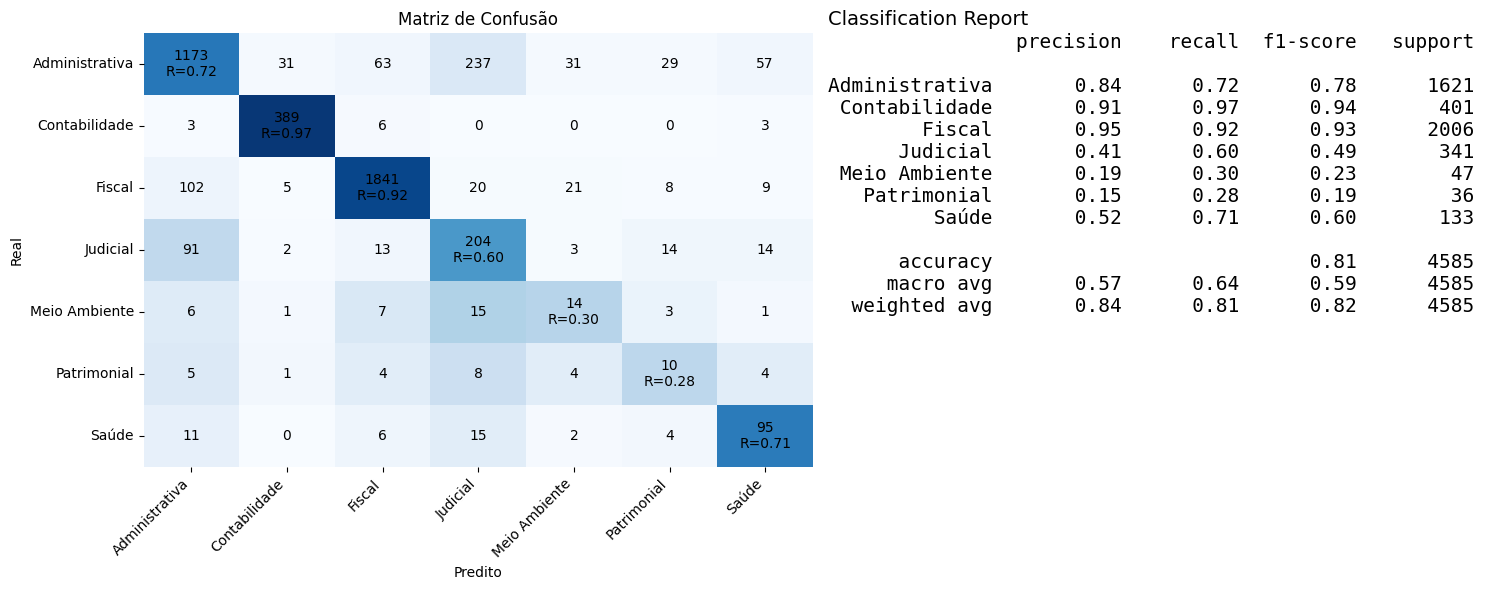

In [79]:
plot_classification_results(y_true=y_test, y_pred=y_pred_rf, dict_encod=dict_encod)

## 3.2 - Naive Bayes

### 3.2.1 - Unbalanced

In [80]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)

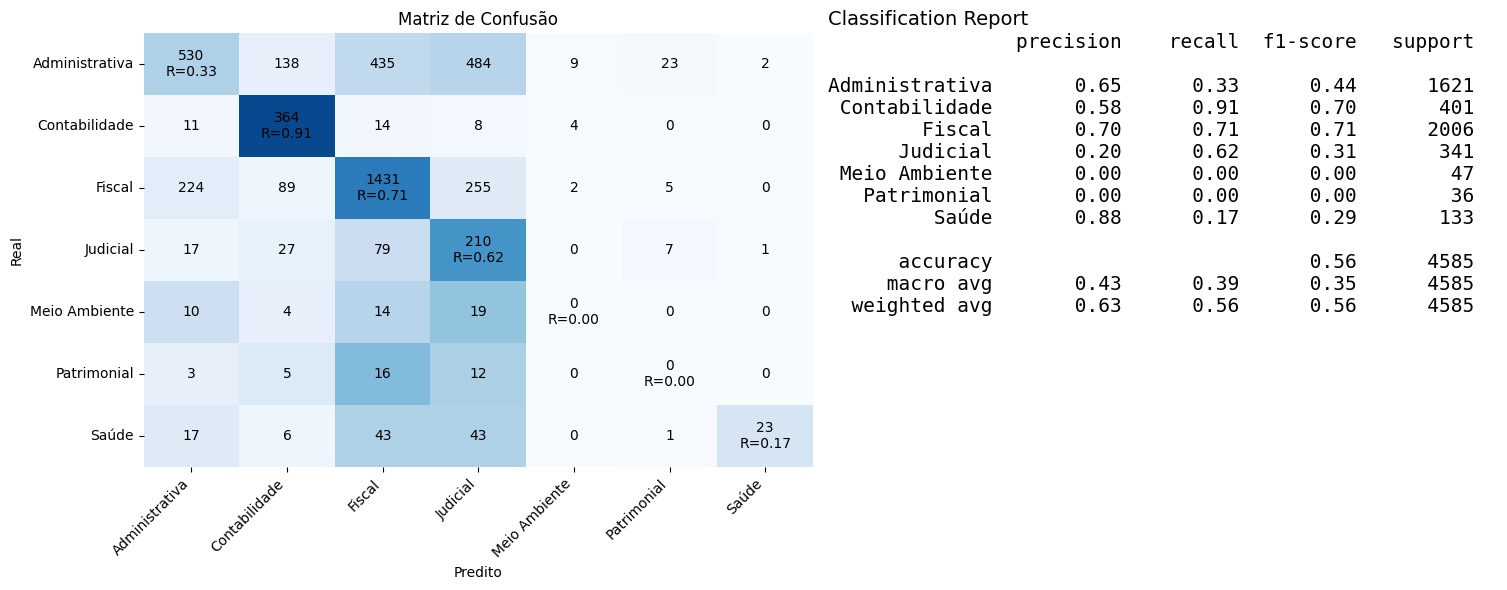

In [81]:
plot_classification_results(y_true=y_test, y_pred=y_pred_nb, dict_encod=dict_encod)

### 3.2.2 - Balanced

In [82]:
nb_clf = GaussianNB()
nb_clf.fit(X_train_balanced, y_train_balanced)

y_pred_nb = nb_clf.predict(X_test)

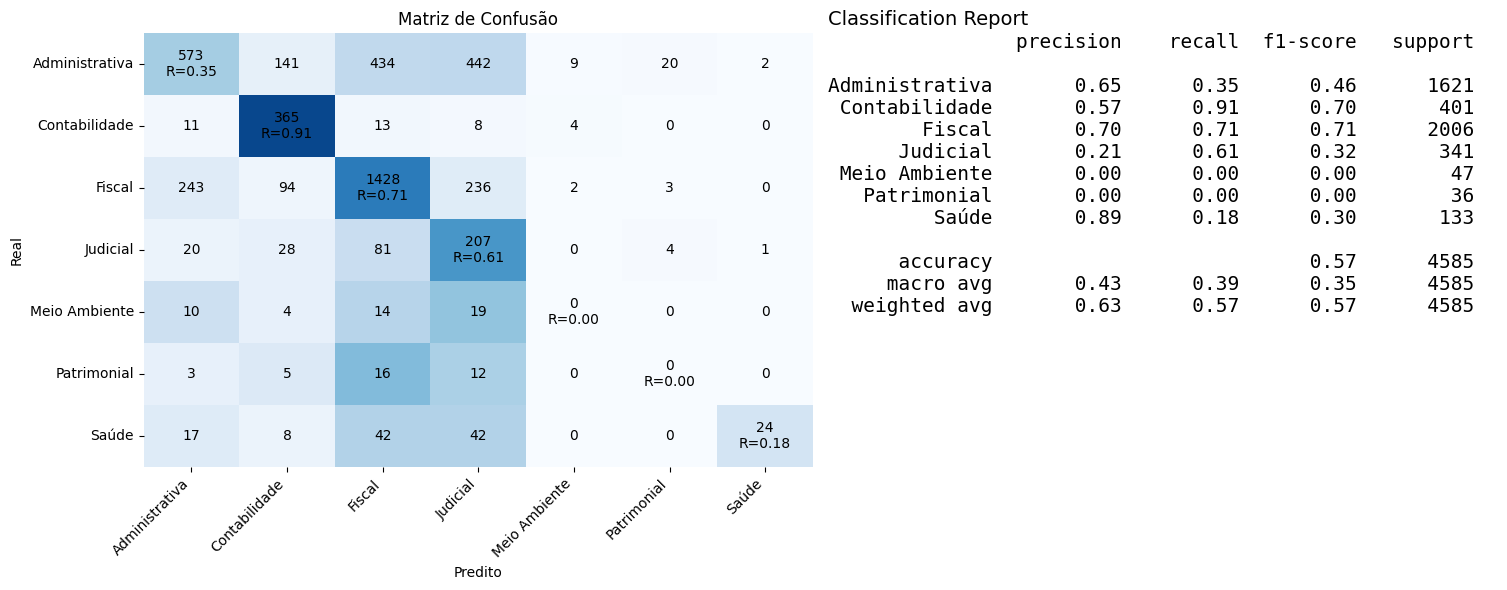

In [83]:
plot_classification_results(y_true=y_test, y_pred=y_pred_nb, dict_encod=dict_encod)

## 3.3 - SVM

### 3.3.1 - Unbalanced - Weight balanced

In [ ]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(class_weight='balanced')
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

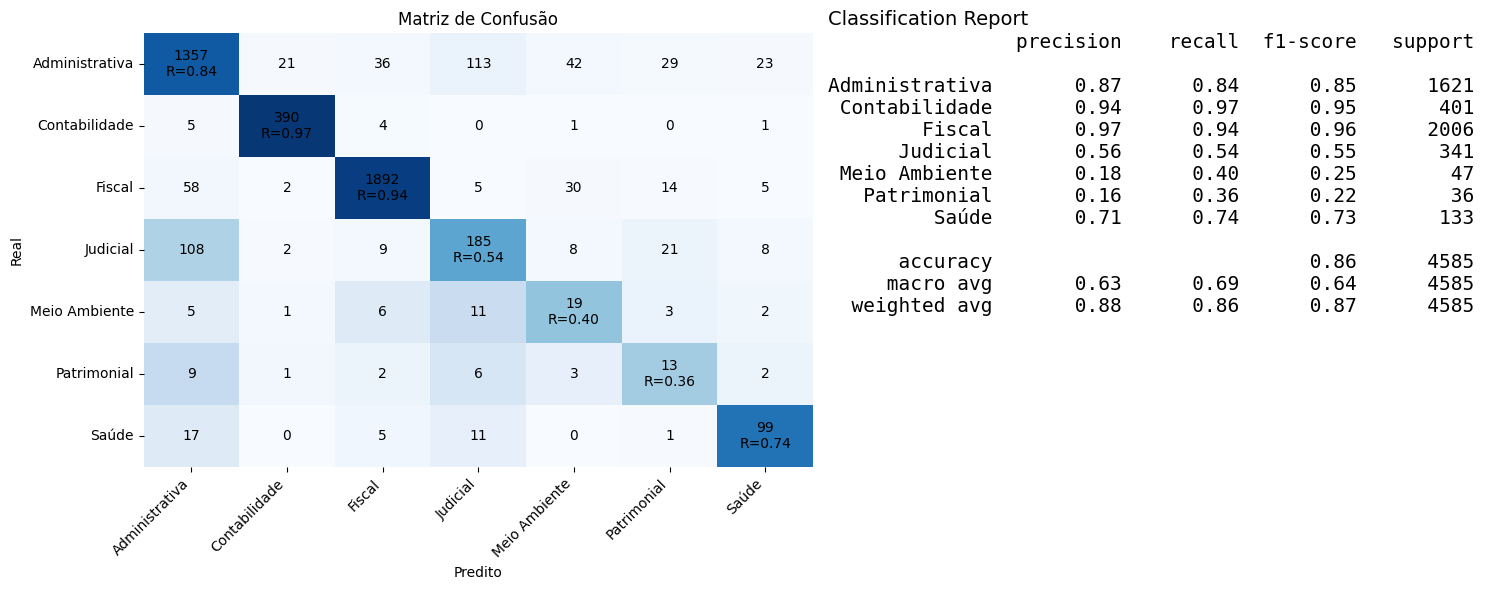

In [88]:
plot_classification_results(y_true=y_test, y_pred=y_pred_svm, dict_encod=dict_encod)

### 3.3.2 - Unbalanced - No Weight Balanced

In [89]:
svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

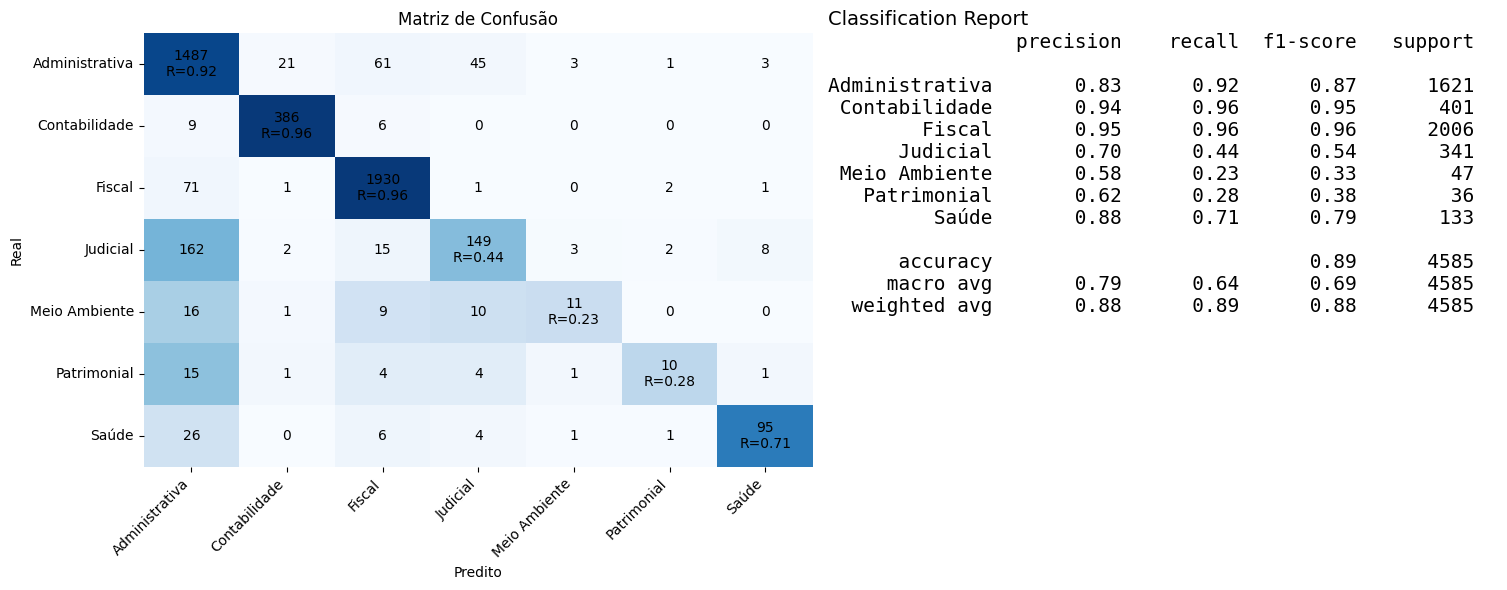

In [90]:
plot_classification_results(y_true=y_test, y_pred=y_pred_svm, dict_encod=dict_encod)

### 3.3.3 - Balanced

In [91]:
svm_clf = LinearSVC()
svm_clf.fit(X_train_balanced, y_train_balanced)

y_pred_svm = svm_clf.predict(X_test)

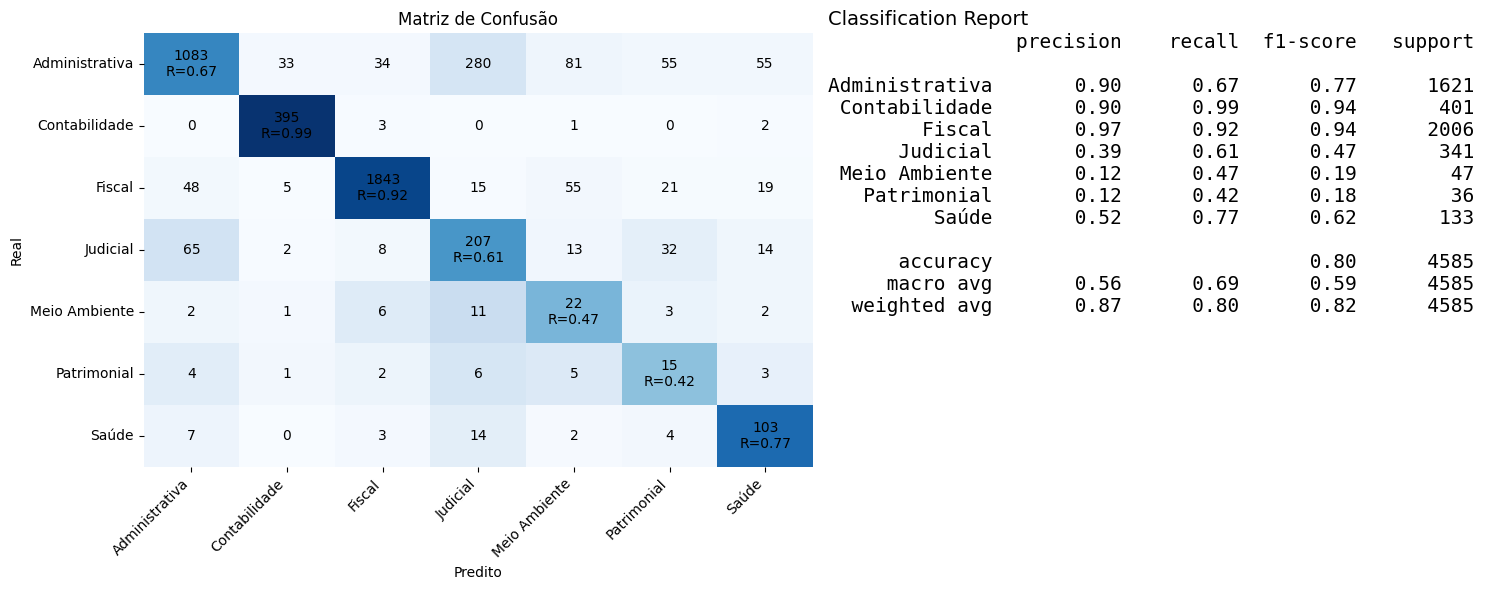

In [92]:
plot_classification_results(y_true=y_test, y_pred=y_pred_svm, dict_encod=dict_encod)

## 3.4 - Gradiant Boosting

### 3.4.1 - Unbalanced - Weight Balanced

In [96]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf = HistGradientBoostingClassifier(class_weight='balanced')
gb_clf.fit(X_train, y_train)

y_pred_gb = gb_clf.predict(X_test)

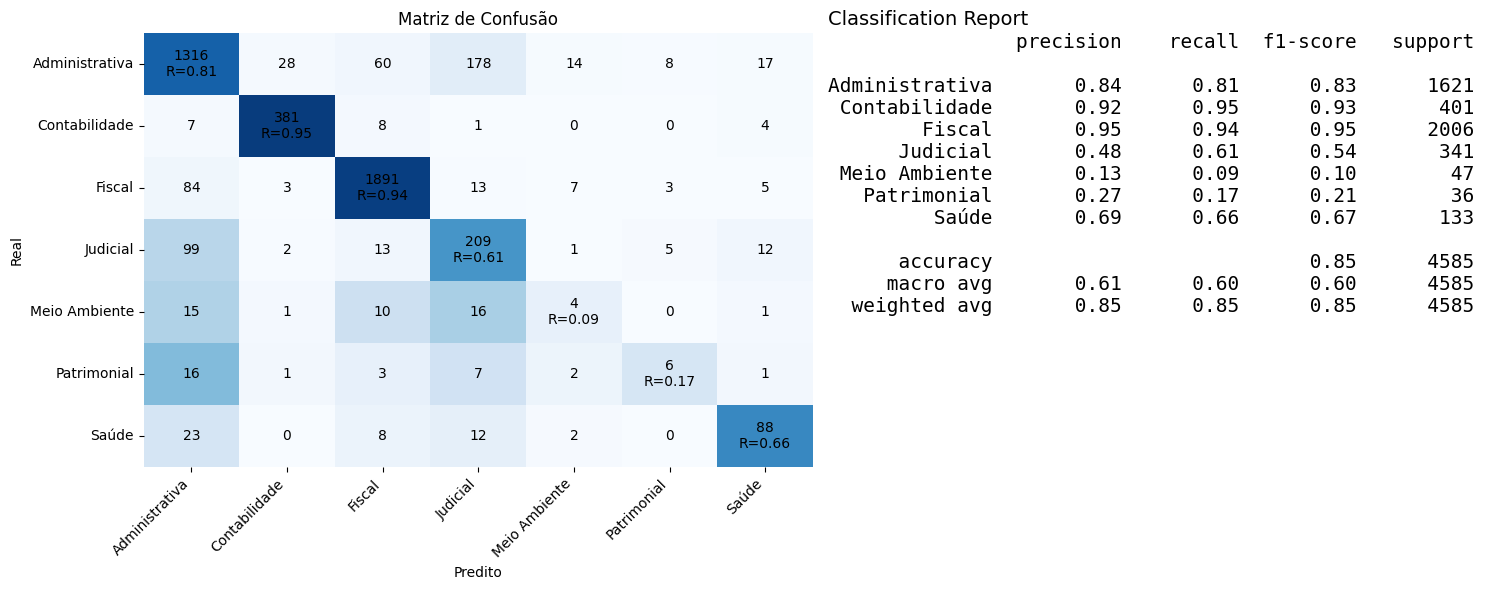

In [97]:
plot_classification_results(y_true=y_test, y_pred=y_pred_gb, dict_encod=dict_encod)

### 3.4.2 - Unbalanced - No Weight Balanced

In [98]:
gb_clf = HistGradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

y_pred_gb = gb_clf.predict(X_test)

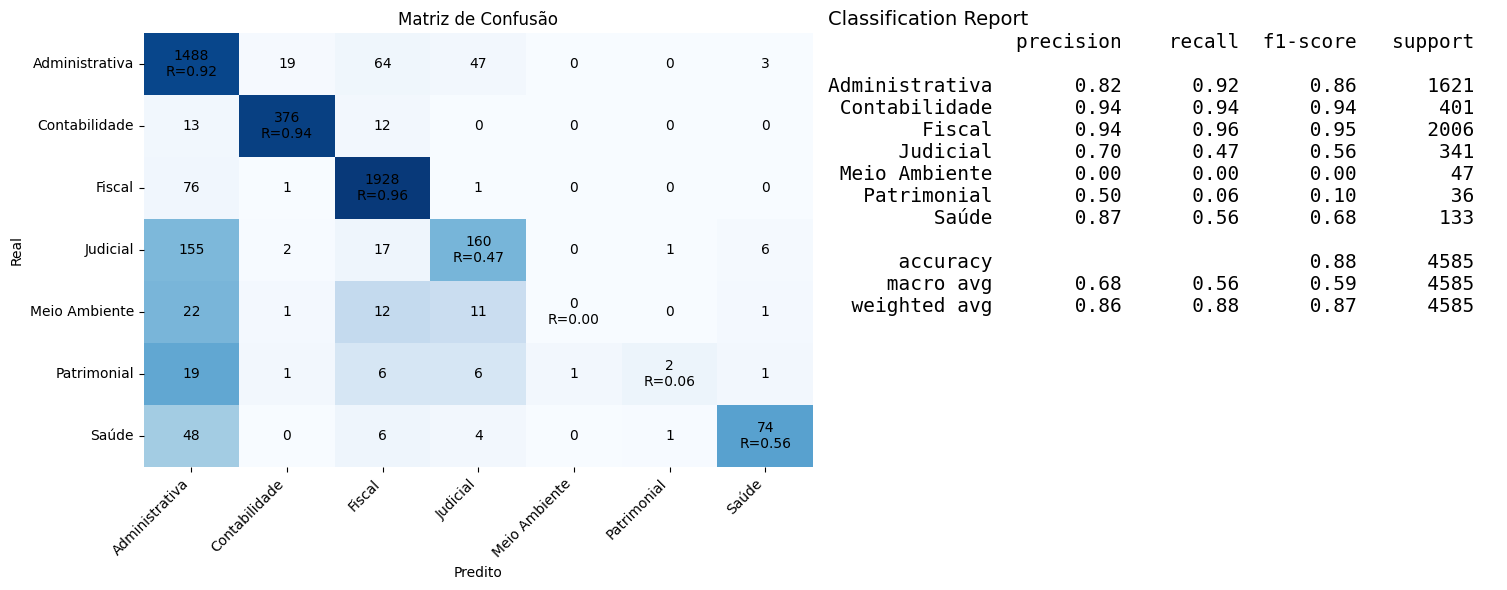

In [99]:
plot_classification_results(y_true=y_test, y_pred=y_pred_gb, dict_encod=dict_encod)

### 3.4.3 - Balanced

In [100]:
gb_clf = HistGradientBoostingClassifier()
gb_clf.fit(X_train_balanced, y_train_balanced)

y_pred_gb = gb_clf.predict(X_test)

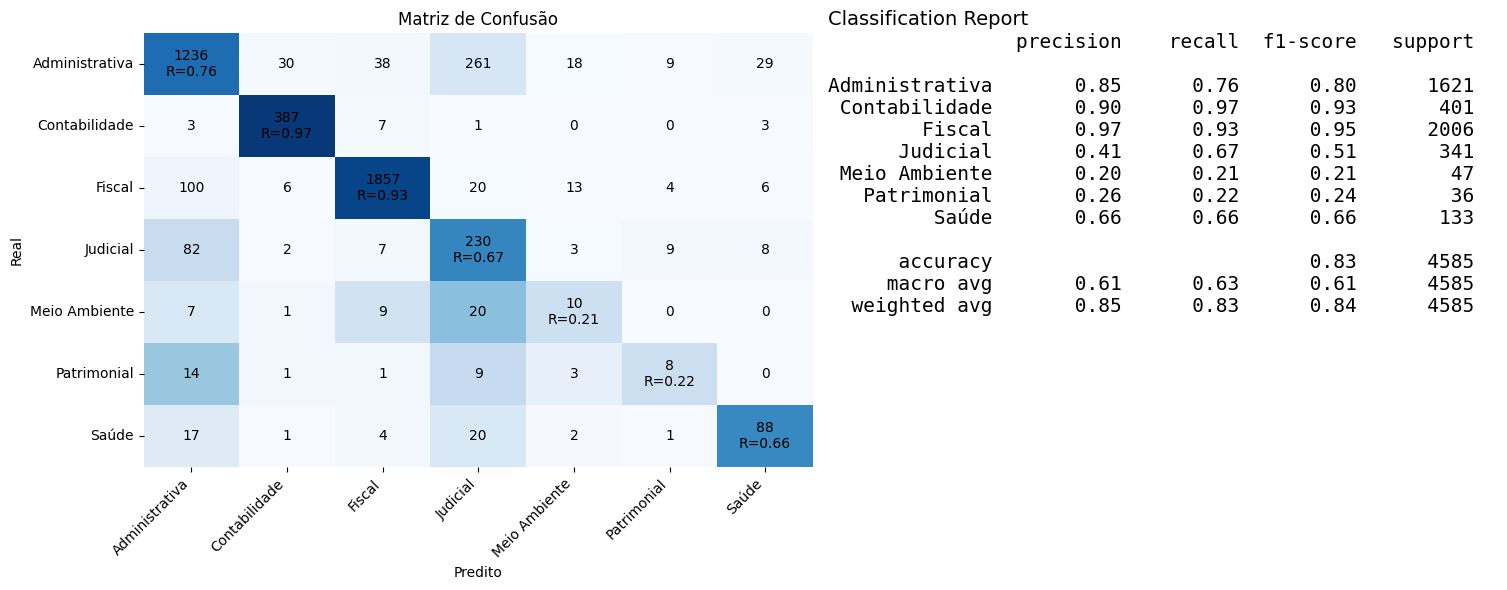

In [102]:
plot_classification_results(y_true=y_test, y_pred=y_pred_gb, dict_encod=dict_encod)

## 3.5 - Voting Classifier

In [107]:
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(class_weight='balanced') # Random Forest
clf2 = LinearSVC(class_weight='balanced') # SVM
clf3 = LinearSVC() # SVM

voting_clf = VotingClassifier(estimators=[
    ('Random Forest', clf1),
    ('SVM', clf2),
    ('SVM_Unbalanced', clf3)
], voting='hard')

voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)

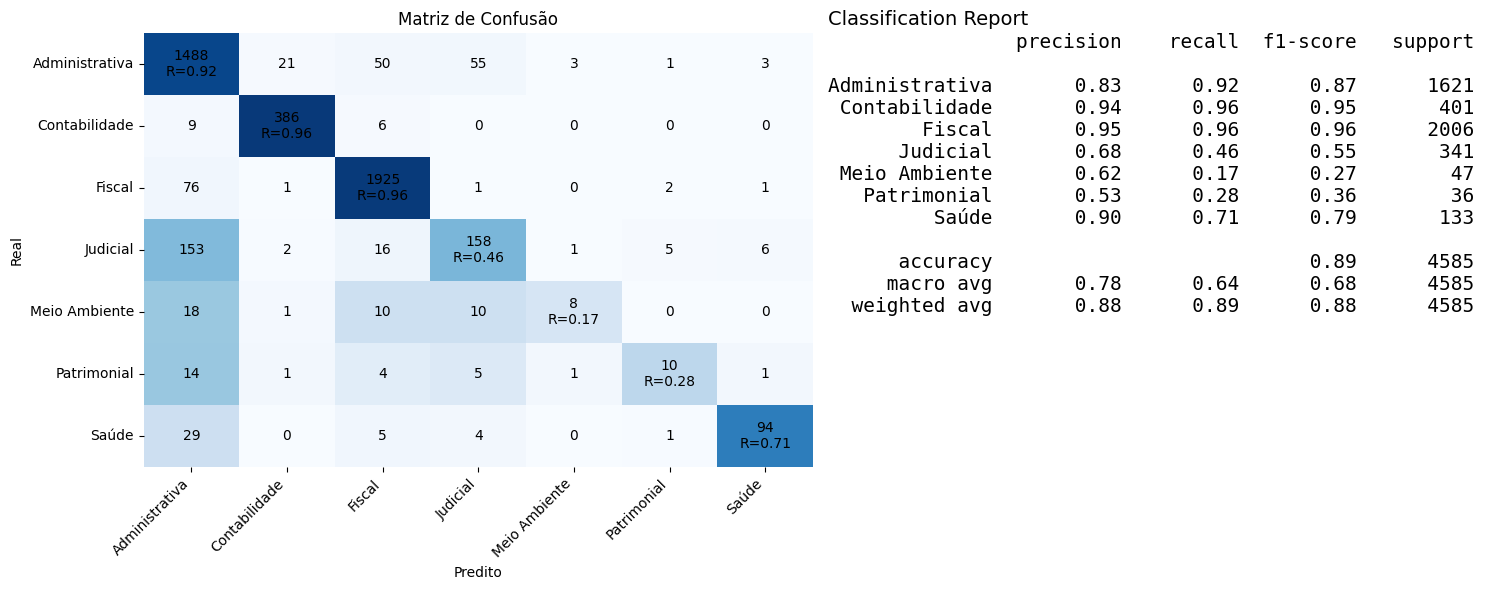

In [108]:
plot_classification_results(y_true=y_test, y_pred=y_pred_voting, dict_encod=dict_encod)

## 3.6 - Stacking Classifier

In [109]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(estimators=[
    ('Random Forest', clf1),
    ('SVM', clf2),
    ('SVM_Unbalanced', clf3)
])

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)

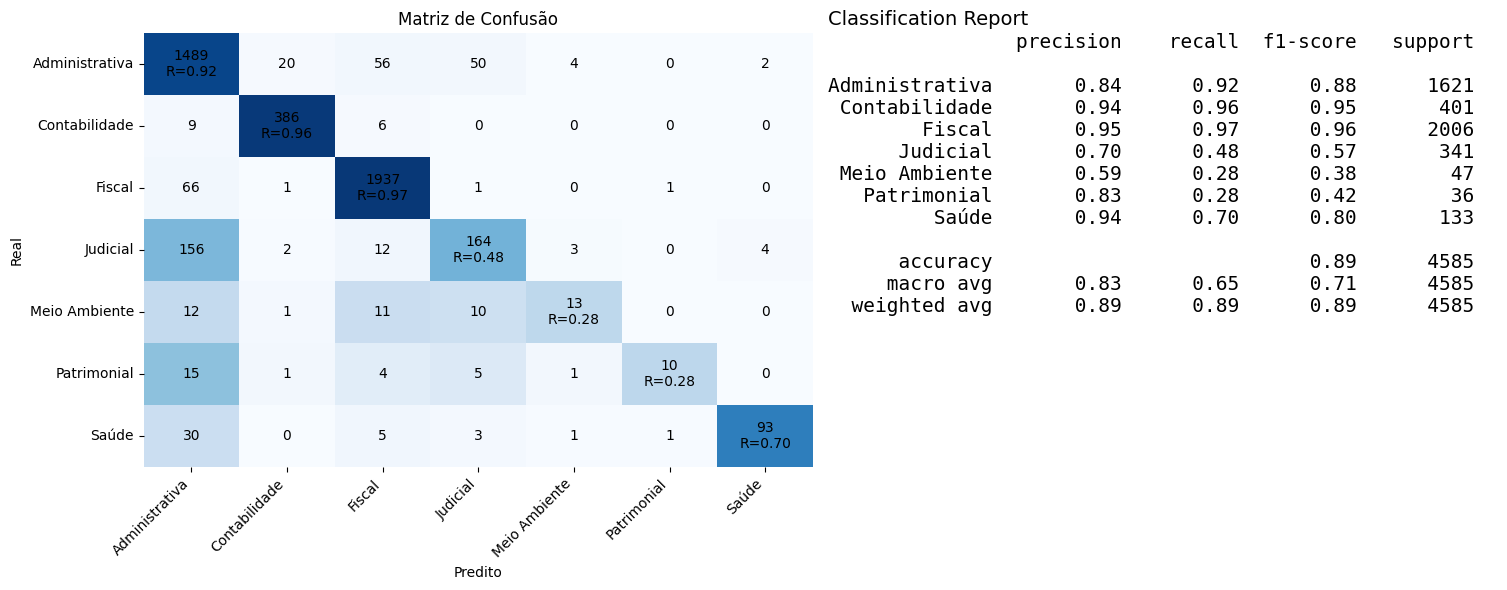

In [110]:
plot_classification_results(y_true=y_test, y_pred=y_pred_stacking, dict_encod=dict_encod)

In [111]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf = StackingClassifier(estimators=[
    ('Random Forest', clf1),
    ('SVM', clf2),
    ('SVM_Unbalanced', clf3)
], final_estimator=LogisticRegression(class_weight='balanced'))

stacking_clf.fit(X_train, y_train)
y_pred_stacking = stacking_clf.predict(X_test)

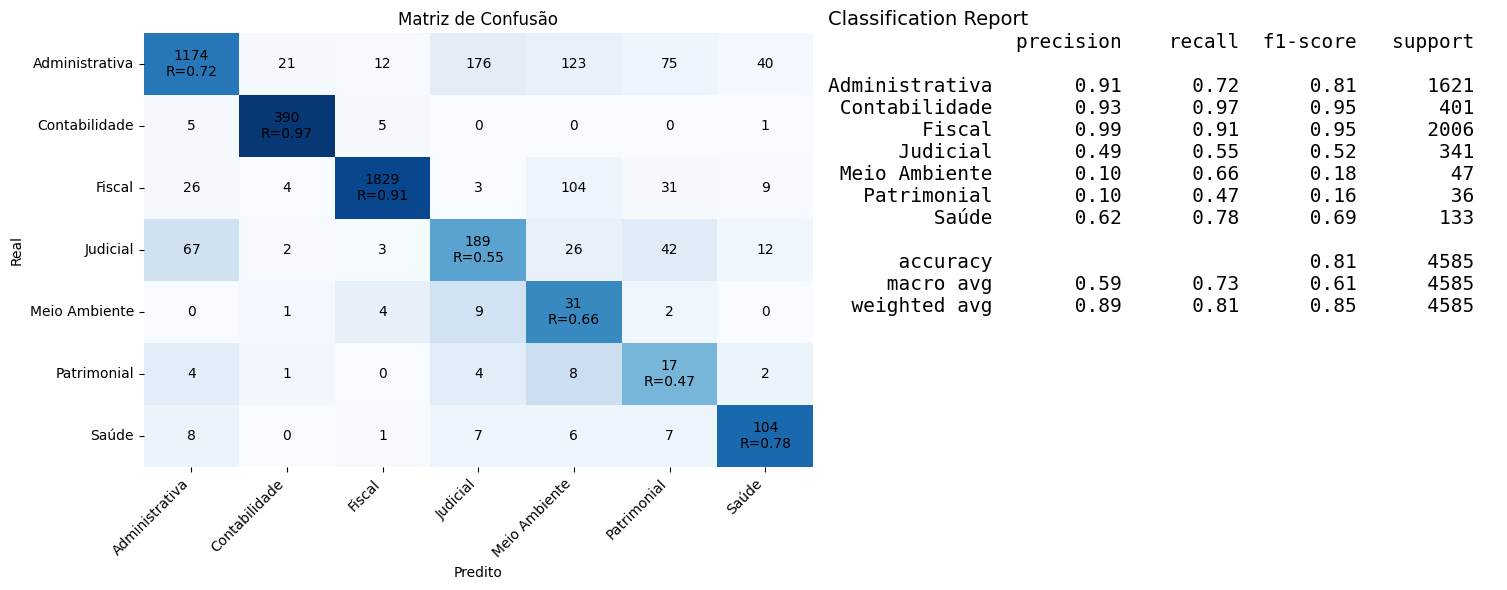

In [112]:
plot_classification_results(y_true=y_test, y_pred=y_pred_stacking, dict_encod=dict_encod)